In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import random
import cv2
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

ImportError: No module named 'cv2'

In [125]:
#import os, cv2, random
pixel_depth = 255.0  # Number of levels per pixel.

TRAIN_DIR = 'cat_dog_train/'
TEST_DIR = 'cat_dog_test/'

ROWS = 100
COLS = 100
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:2000] + train_cats[:2000]
random.shuffle(train_images)
test_images =  test_images

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS,CHANNELS), dtype=np.float)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)


print("Train shape: {}".format(train.shape))

labels = []
for i in train_images:
    if 'dog' in i.split("/")[1]:
        labels.append(1)
    else:
        labels.append(0)

Processed 0 of 4000
Processed 250 of 4000
Processed 500 of 4000
Processed 750 of 4000
Processed 1000 of 4000
Processed 1250 of 4000
Processed 1500 of 4000
Processed 1750 of 4000
Processed 2000 of 4000
Processed 2250 of 4000
Processed 2500 of 4000
Processed 2750 of 4000
Processed 3000 of 4000
Processed 3250 of 4000
Processed 3500 of 4000
Processed 3750 of 4000
Train shape: (4000, 100, 100, 3)


In [126]:
print(train[0][0])

[[ 118.  122.  116.]
 [ 120.  125.  116.]
 [ 122.  129.  116.]
 [ 135.  142.  127.]
 [ 128.  138.  120.]
 [ 133.  128.  104.]
 [   5.   12.    8.]
 [ 113.  127.  129.]
 [ 124.  129.  117.]
 [ 120.  128.  117.]
 [ 119.  127.  116.]
 [ 121.  129.  118.]
 [ 120.  127.  117.]
 [ 113.  127.  115.]
 [ 112.  126.  114.]
 [ 111.  125.  113.]
 [ 109.  123.  111.]
 [ 109.  121.  115.]
 [ 106.  118.  112.]
 [ 107.  119.  113.]
 [ 106.  118.  112.]
 [ 100.  114.  108.]
 [  99.  113.  107.]
 [  98.  112.  106.]
 [  97.  111.  105.]
 [  95.  109.  103.]
 [  93.  109.  102.]
 [  92.  108.  101.]
 [  89.  105.   98.]
 [  86.  102.   95.]
 [  84.  100.   93.]
 [  81.   97.   90.]
 [  80.   96.   89.]
 [  78.   94.   87.]
 [  72.   93.   85.]
 [  71.   92.   84.]
 [  70.   91.   83.]
 [  69.   90.   82.]
 [  66.   86.   81.]
 [  64.   84.   79.]
 [  63.   83.   78.]
 [  61.   81.   76.]
 [  60.   80.   75.]
 [  57.   77.   72.]
 [  56.   76.   71.]
 [  54.   74.   69.]
 [  51.   71.   66.]
 [  48.   67.

In [127]:
test = prep_data(test_images)
print("Test shape: {}".format(test.shape))


Processed 0 of 12500
Processed 250 of 12500
Processed 500 of 12500
Processed 750 of 12500
Processed 1000 of 12500
Processed 1250 of 12500
Processed 1500 of 12500
Processed 1750 of 12500
Processed 2000 of 12500
Processed 2250 of 12500
Processed 2500 of 12500
Processed 2750 of 12500
Processed 3000 of 12500
Processed 3250 of 12500
Processed 3500 of 12500
Processed 3750 of 12500
Processed 4000 of 12500
Processed 4250 of 12500
Processed 4500 of 12500
Processed 4750 of 12500
Processed 5000 of 12500
Processed 5250 of 12500
Processed 5500 of 12500
Processed 5750 of 12500
Processed 6000 of 12500
Processed 6250 of 12500
Processed 6500 of 12500
Processed 6750 of 12500
Processed 7000 of 12500
Processed 7250 of 12500
Processed 7500 of 12500
Processed 7750 of 12500
Processed 8000 of 12500
Processed 8250 of 12500
Processed 8500 of 12500
Processed 8750 of 12500
Processed 9000 of 12500
Processed 9250 of 12500
Processed 9500 of 12500
Processed 9750 of 12500
Processed 10000 of 12500
Processed 10250 of 12

In [128]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(ROWS, COLS,CHANNELS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy',optimizer="adam",metrics=["accuracy"])
    return model


model = catdog()

nb_epoch = 30
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=1)
    return predictions, history

predictions, history = run_catdog()

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 6s - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6934 - val_acc: 0.4850
Epoch 2/30
3000/3000 [==============================] - 5s - loss: 0.6933 - acc: 0.5080 - val_loss: 0.6928 - val_acc: 0.5710
Epoch 3/30
3000/3000 [==============================] - 6s - loss: 0.6881 - acc: 0.5327 - val_loss: 0.6862 - val_acc: 0.5480
Epoch 4/30
3000/3000 [==============================] - 6s - loss: 0.6695 - acc: 0.5800 - val_loss: 0.6471 - val_acc: 0.5970
Epoch 5/30
3000/3000 [==============================] - 6s - loss: 0.6461 - acc: 0.6127 - val_loss: 0.6951 - val_acc: 0.6110
Epoch 6/30
3000/3000 [==============================] - 5s - loss: 0.6192 - acc: 0.6570 - val_loss: 0.6286 - val_acc: 0.6290
Epoch 7/30
3000/3000 [==============================] - 5s - loss: 0.5981 - acc: 0.6827 - val_loss: 0.6109 - val_acc: 0.6580
Epoch 8/30
3000/3000 [==============================] - 6s - loss: 0.5876 - a

In [129]:
loss = history.losses
val_loss = history.val_losses
print(loss)

[0.69320958312352499, 0.69328340148925782, 0.68808240954081212, 0.66949537992477415, 0.64609971539179489, 0.61918853171666466, 0.59809511772791546, 0.5875856153170268, 0.57679648001988726, 0.56135395224889117, 0.55571370140711462, 0.54090894683202106, 0.53184805854161576, 0.51866554860273995, 0.51287961006164551, 0.48691322779655455, 0.47551760927836101, 0.46144780842463173, 0.43669271405537924, 0.43264265791575113, 0.40551945340633394, 0.38523775239785513, 0.36672593168417611, 0.34217713312307996, 0.32109960842132568, 0.30236859258015952, 0.27361100841561953, 0.26797440187136334, 0.23413415040572486, 0.21253406997521718]


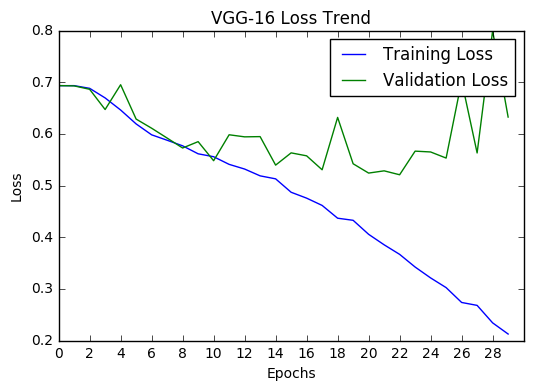

In [130]:

loss = history.losses
val_loss = history.val_losses



plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [131]:

predictions = model.predict(test, verbose=1)



12500/12500 [==============================] - 7s     


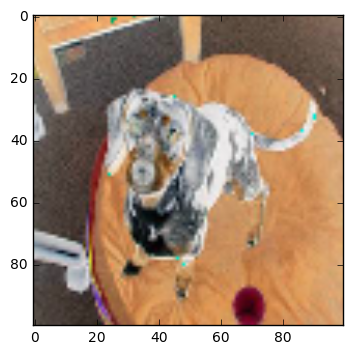

I am 99.89% sure this is a Dog


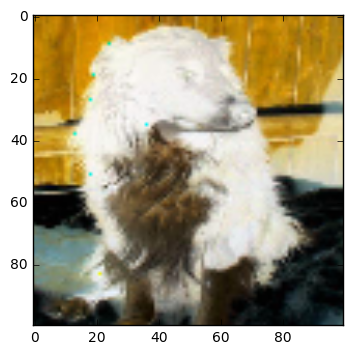

I am 99.54% sure this is a Cat


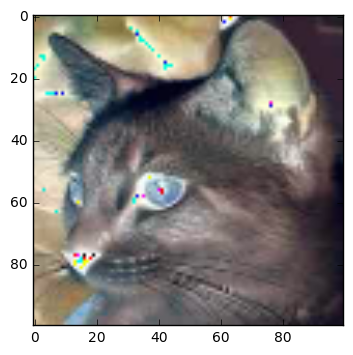

I am 99.81% sure this is a Dog


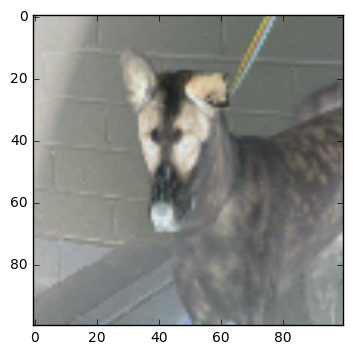

I am 92.37% sure this is a Dog


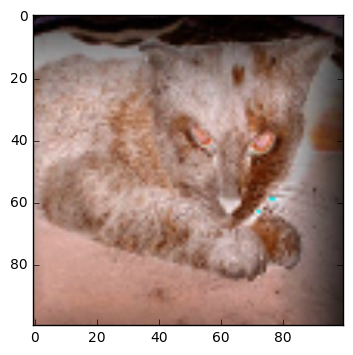

I am 99.51% sure this is a Cat


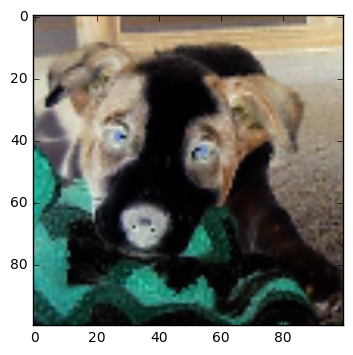

I am 91.36% sure this is a Cat


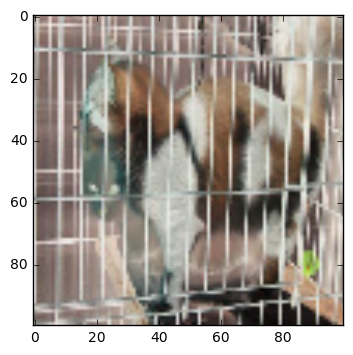

I am 88.52% sure this is a Cat


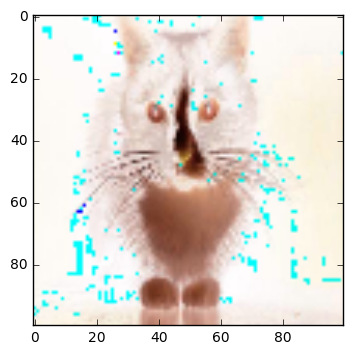

I am 100.00% sure this is a Cat


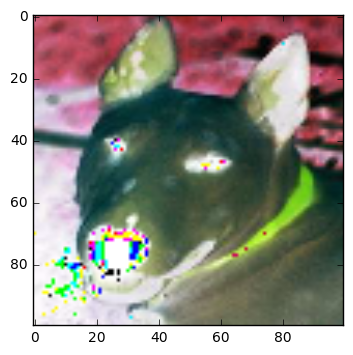

I am 99.37% sure this is a Dog


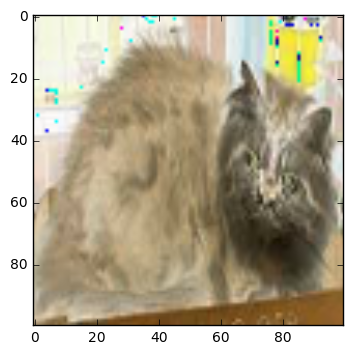

I am 97.74% sure this is a Cat


In [132]:
for i in range(0,10):
    plt.imshow(test[i])
    plt.show()
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

In [133]:
open("result.txt", 'w')
for i in range(len(test)):
    with open('result.txt', 'a') as file:
        string = str(i+1)+","+("%.2f" % predictions[i][0])+"\n"
        file.write(string)

In [134]:
print(len(test))

12500
